In [1]:
# Import package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from timeit import default_timer as timer 

# Load CSV files

In [2]:
start = timer()
# 
prediction_info = dict()
# 
file = 'paysim.csv'
path = '../Data/'

paysim = pd.read_csv(path+file)
# 
paysim = pd.get_dummies(paysim, drop_first=True)
# 
end = timer()
print(f'{(end - start)} seconds elapsed.')

8.085496229 seconds elapsed.


In [3]:
paysim.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Display Data for both DataFrames

In [4]:
paysim.head()

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,diffBalanceOrig,diffBalanceDest,transType_CASH_OUT,transType_DEBIT,transType_PAYMENT,transType_TRANSFER,nameDest_M
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,9839.64,0,0,1,0,1
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,1864.28,0,0,1,0,1
2,1,181.00,181.0,0.00,0.0,0.0,1,0.0,181.00,0,0,0,1,0
3,1,181.00,181.0,0.00,21182.0,0.0,1,0.0,21363.00,1,0,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,11668.14,0,0,1,0,1


### Create X & y for both CSV files

In [5]:
# X, y full data
y =  paysim['isFraud']
X =  paysim.loc[:, paysim.columns != 'isFraud']
# 
seed = 11
# 

In [6]:
X.sample(5)

,step,amount,oldbalanceOrig,newbalanceOrig,oldbalanceDest,newbalanceDest,diffBalanceOrig,diffBalanceDest,transType_CASH_OUT,transType_DEBIT,transType_PAYMENT,transType_TRANSFER,nameDest_M
5932021,404,202655.52,949934.49,1152590.01,459208.99,256553.47,405311.04,405311.04,0,0,0,0,0
1585470,155,223409.26,5205833.48,5429242.75,1986344.37,1762935.10,446818.53,446818.53,0,0,0,0,0
1321617,136,5052.02,0.00,0.00,0.00,0.00,5052.02,5052.02,0,0,1,0,1
5097624,355,70732.51,7349136.79,7419869.30,467655.45,396922.94,141465.02,141465.02,0,0,0,0,0
1271213,135,74263.91,18868.00,0.00,30530.00,104793.91,55395.91,0.00,0,0,0,1,0


In [7]:
y.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### imblearn under sampling (RandomUnderSampler)

In [8]:
start = timer()
# 
from imblearn.under_sampling import RandomUnderSampler
# 
params_fixed = {
    'sampling_strategy' : 'auto',
    'random_state' : seed,
    'replacement' : False,
}
# # Model
rus = RandomUnderSampler(**params_fixed)

# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)
print('Original Non standarized dataset shape:', len(y))
print('Resample Non standarized dataset shape', len(y_rus))
print('\n')

end = timer()
print(f'{(end - start)} seconds elapsed.')

Original Non standarized dataset shape: 6362620
Resample Non standarized dataset shape 16426


2.7463999539999993 seconds elapsed.


### Synthetic Minority Oversampling Technique (SMOTE)

In [9]:
start = timer()
# import library
from imblearn.over_sampling import SMOTE
# 
params_fixed = {'sampling_strategy' : 'not majority',
                'random_state' : seed,
                'k_neighbors' : (5),
                'n_jobs' : (-1),
               }
# Model
oversample = SMOTE(**params_fixed)
# 

# fit predictor and target variable
x_smote, y_smote = oversample.fit_resample(X, y)

print('SMOTE Original standarized dataset shape', len(y))
print('SMOTE Resample standarized dataset shape', len(y_smote))
print('\n')

end = timer()
print(f'{(end - start)} seconds elapsed.')

SMOTE Original standarized dataset shape 6362620
SMOTE Resample standarized dataset shape 12708814


6.926048885 seconds elapsed.


# Train Test Split

In [10]:
start = timer()
from sklearn.model_selection import train_test_split
# 
t_size=0.25
# Random standarized under-sampling with imblearn
X_train_rus, X_test_rus, y_train_rus, y_test_rus = train_test_split(x_rus, y_rus, test_size=t_size, 
                                                                    random_state=seed, stratify=y_rus)

# Non Standarized Full Dataset
X_train_nsf, X_test_nsf, y_train_nsf, y_test_nsf = train_test_split(X, y, test_size=t_size, 
                                                                    random_state=seed, stratify=y)

# Non Standarized over-sampling SMOTE Dataset
X_train_nso, X_test_nso, y_train_nso, y_test_nso = train_test_split(x_smote, y_smote, test_size=t_size, 
                                                                    random_state=seed, stratify=y_smote)

end = timer()
print(f'{(end - start)} seconds elapsed.')

11.496947894000002 seconds elapsed.


### Import Model/Search/Matrics

In [11]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# XG Boost Classifier
from xgboost import XGBClassifier
# Light GBM Classifier
from lightgbm import LGBMClassifier
# Support Vector Machine
from sklearn import svm
# Import StandardScaler
from sklearn.preprocessing import StandardScaler
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler
#

#### Store Model Stats for comparison

In [12]:
prediction_info = dict()
# 
prediction_info = {"ID" : [],
                   "Algorithm" : [],
                   "TrainingTime_sec": [],
                   "PredictionTime_sec": [],
                   "False Negative" : [],
                   "False Positive" : [],
                   "Total Records": [],
                  }
# 
keys = ["ID", "Algorithm", "TrainingTime_sec", "PredictionTime_sec", "False Negative", "False Positive","Total Records"]
# 

# Random Forest

In [13]:
# For prediction_info
ID = 'RF'
# steps = [()] RandomForestClassifier
params_rfc = {'n_jobs' : (-1),
              'random_state' : seed,
             }
# Pipeline
rfc_scaler_rus = [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(**params_rfc))]
rfc_normal_rus = [('normal', MinMaxScaler()), ('rfc', RandomForestClassifier(**params_rfc))]
rfc_scaler_nso = [('scaler', StandardScaler()), ('rfc', RandomForestClassifier(**params_rfc))]
rfc_normal_nsf = [('normal', MinMaxScaler()), ('rfc', RandomForestClassifier(**params_rfc))] 
# Pipeline
# under sample
pipe_scaler_rus = Pipeline(rfc_scaler_rus)
pipe_normal_rus = Pipeline(rfc_normal_rus)
# Over sample (SMOTE)
pipe_nso = Pipeline(rfc_scaler_nso)
# Full
pipe_nsf = Pipeline(rfc_normal_nsf)

#### Random Forest Model with MinMaxScaler Under sample Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

Pipeline(steps=[('normal', MinMaxScaler()),
                ('rfc', RandomForestClassifier(n_jobs=-1, random_state=11))])


                    RF %-importance
diffBalanceOrig            0.379779
newbalanceOrig             0.159288
oldbalanceOrig             0.110100
amount                     0.066509
nameDest_M                 0.054561
transType_TRANSFER         0.042779
transType_PAYMENT          0.041354
diffBalanceDest            0.036382
transType_CASH_OUT         0.028255
step                       0.028075
newbalanceDest             0.027788
oldbalanceDest             0.024391
transType_DEBIT            0.000738


0.34246885500000346 Sec elapsed.


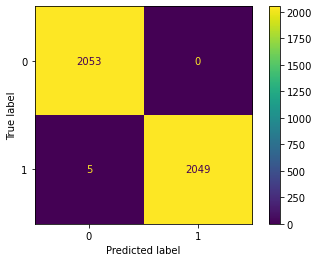

In [14]:
start = timer()
# 
pipe_normal_rus.fit(X_train_rus, y_train_rus)
# 
p_start = timer()
y_predRFC = pipe_normal_rus.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predRFC))
print(pipe_normal_rus)
print('\n')
cm = confusion_matrix(y_test_rus, y_predRFC)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_normal_rus.named_steps['rfc'].classes_)
disp.plot()
#
df = pd.DataFrame(pipe_normal_rus.named_steps['rfc'].feature_importances_, index=X_test_rus.columns, 
                  columns=["RF %-importance"])
print(df.sort_values("RF %-importance", axis=0, ascending=False))
# Log
data = [ID, 'RFC - Normalize - UnderSample', (p_start - start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
# 
end = timer()
# 
print('\n')
print(f'{(end - start)} Sec elapsed.')

### Random Forest Model with StandardScaler Under sample Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

Pipeline(steps=[('scaler', StandardScaler()),
                ('rfc', RandomForestClassifier(n_jobs=-1, random_state=11))])


                    RF %-importance
diffBalanceOrig            0.377032
newbalanceOrig             0.162867
oldbalanceOrig             0.109338
amount                     0.066668
nameDest_M                 0.054033
transType_TRANSFER         0.046070
transType_PAYMENT          0.042159
diffBalanceDest            0.031879
step                       0.029171
transType_CASH_OUT         0.028848
newbalanceDest             0.027801
oldbalanceDest             0.023401
transType_DEBIT            0.000734


0.288108378000004 Sec elapsed.


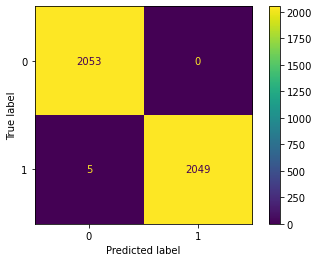

In [15]:
start = timer()
# 
pipe_scaler_rus.fit(X_train_rus, y_train_rus)
# 
p_start = timer()
y_predRFC = pipe_scaler_rus.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predRFC))
print(pipe_scaler_rus)
print('\n')
cm = confusion_matrix(y_test_rus, y_predRFC)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe_scaler_rus.named_steps['rfc'].classes_)
disp.plot()
# 
# print(pipe_normal_rus.named_steps['rfc'])
#
df = pd.DataFrame(pipe_scaler_rus.named_steps['rfc'].feature_importances_, index=X_test_rus.columns, 
                  columns=["RF %-importance"])
print(df.sort_values("RF %-importance", axis=0, ascending=False))
# Log
data = [ID, 'RFC - Standard - UnderSample', (p_start - start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
# 
end = timer()
print('\n')
print(f'{(end - start)} Sec elapsed.')

#### Random Forest Model with NON-Standarized/Normalized Under sample Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

RandomForestClassifier(n_jobs=-1, random_state=11)


                    RF %-importance
diffBalanceOrig            0.385706
newbalanceOrig             0.157473
oldbalanceOrig             0.110658
amount                     0.068351
nameDest_M                 0.058427
transType_TRANSFER         0.046108
transType_PAYMENT          0.041862
diffBalanceDest            0.034018
step                       0.028806
newbalanceDest             0.026155
oldbalanceDest             0.021638
transType_CASH_OUT         0.020089
transType_DEBIT            0.000707


0.29974042399999945 Sec elapsed.


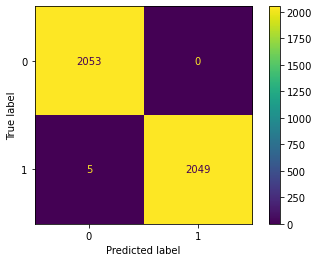

In [16]:
start = timer()
# RF Model with Non Standarized Under sample Data
rfc_ = RandomForestClassifier(**params_rfc)
# 
s_start = timer()
# 
rfc_.fit(X_train_rus, y_train_rus)
#
p_start = timer()
y_predRFC = rfc_.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predRFC))
cm = confusion_matrix(y_test_rus, y_predRFC)
print(rfc_)
print('\n')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_.classes_)
disp.plot()
# 
df = pd.DataFrame(rfc_.feature_importances_, index=X_test_rus.columns, columns=["RF %-importance"])
print(df.sort_values("RF %-importance", axis=0, ascending=False))
# 
data = [ID, 'RFC - NonStandard - UnderSample', (p_start - s_start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
# 
end = timer()
print('\n')
print(f'{(end - start)} Sec elapsed.')

#### Random Forest Model with NON-Standarized Full Data

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      1.00      1.00      2053

    accuracy                           1.00   1590655
   macro avg       1.00      1.00      1.00   1590655
weighted avg       1.00      1.00      1.00   1590655

RandomForestClassifier(n_jobs=-1, random_state=11)


                    RF %-importance
newbalanceOrig             0.341030
diffBalanceOrig            0.211910
newbalanceDest             0.095807
amount                     0.090746
diffBalanceDest            0.087591
oldbalanceOrig             0.067213
step                       0.032396
oldbalanceDest             0.031101
transType_TRANSFER         0.027329
transType_CASH_OUT         0.012582
transType_PAYMENT          0.001332
nameDest_M                 0.000858
transType_DEBIT            0.000104


2.7871904502666665 Min elapsed.


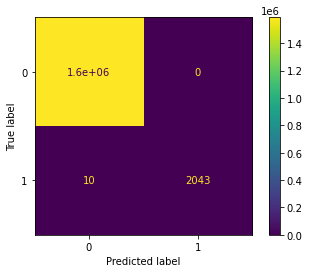

In [17]:
start = timer()
# RF Model with Non Standarized Full data
rfc_nsf = RandomForestClassifier(**params_rfc)
# 
s_start = timer()
rfc_nsf.fit(X_train_nsf, y_train_nsf)
# 
p_start = timer()
y_predRFC_nsf = rfc_nsf.predict(X_test_nsf)
p_end = timer()
# 
print(classification_report(y_test_nsf, y_predRFC_nsf))
print(rfc_nsf)
print('\n')
cm = confusion_matrix(y_test_nsf, y_predRFC_nsf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_nsf.classes_)
disp.plot()
# 
df = pd.DataFrame(rfc_nsf.feature_importances_, index=X_test_nsf.columns, columns=["RF %-importance"])
print(df.sort_values("RF %-importance", axis=0, ascending=False))
# 
data = [ID, 'RFC - NonStandard - Full', (p_start - s_start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print('\n')
print(f'{(end - start)/60} Min elapsed.')

#### Random Forest Model with NON-Standarized SMOTE Dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      1.00      1.00   1588602

    accuracy                           1.00   3177204
   macro avg       1.00      1.00      1.00   3177204
weighted avg       1.00      1.00      1.00   3177204

RandomForestClassifier(n_jobs=-1, random_state=11)


                    RF %-importance
diffBalanceOrig            0.390881
newbalanceOrig             0.157252
oldbalanceOrig             0.118350
nameDest_M                 0.057839
amount                     0.054603
transType_TRANSFER         0.051222
transType_PAYMENT          0.045937
diffBalanceDest            0.041483
step                       0.023861
newbalanceDest             0.020794
transType_CASH_OUT         0.020553
oldbalanceDest             0.016444
transType_DEBIT            0.000781


5.5428361614499995 Min elapsed.


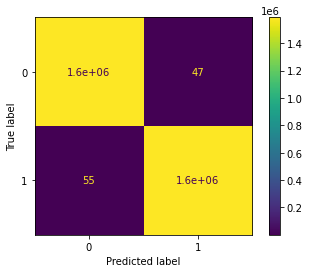

In [18]:
start = timer()
# RF Model SMOTE
rfc_ = RandomForestClassifier(**params_rfc)
# 
s_start = timer()
rfc_.fit(X_train_nso, y_train_nso)
# 
p_start = timer()
y_predRFC_ = rfc_.predict(X_test_nso)
p_end = timer()
# 
print(classification_report(y_test_nso, y_predRFC_))
print(rfc_)
print('\n')
cm = confusion_matrix(y_test_nso, y_predRFC_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_.classes_)
disp.plot()
# 
df = pd.DataFrame(rfc_.feature_importances_, index=X_test_nso.columns, columns=["RF %-importance"])
print(df.sort_values("RF %-importance", axis=0, ascending=False))
# 
data = [ID, 'RFC - NonStandard - OverSample', (p_start - s_start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print('\n')
print(f'{(end - start)/60} Min elapsed.')

#### Random Forest Model NON-Standard Under-sampled RandomizedSearchCV

In [19]:
start = timer()
#Create a Random Forest Classifier
rfc_nsf = RandomForestClassifier(**params_rfc)

# RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# 
rfc_random = RandomizedSearchCV(estimator = rfc_nsf, param_distributions = random_grid, n_iter = 100, 
                                cv = 3, verbose=2, random_state=seed, n_jobs = -1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107



{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': False}


4.097626969666665 Min elapsed.


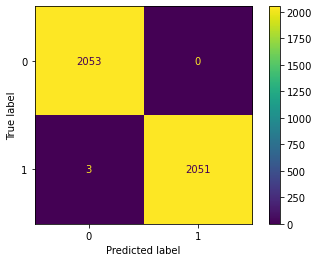

In [20]:
s_start = timer()
#Train the model using the training sets - under sample standarized
rfc_random.fit(X_train_rus, y_train_rus)
# 
p_start = timer()
y_prednsf = rfc_random.predict(X_test_rus)
p_end = timer()
# 
print('\n')
print(classification_report(y_test_rus, y_prednsf))
print('\n')
cm = confusion_matrix(y_test_rus, y_prednsf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rfc_random.classes_)
disp.plot()
# 
data = [ID, 'RFC - NonStandard - UnderSample - RandomGridSearch', (p_start - s_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
print(rfc_random.best_params_)
print('\n')
end = timer()
print(f'{(end - start)/60} Min elapsed.')

# XGB Classifier

#### XGB Classifier Model Pipeline

In [21]:
# For prediction_info
ID = 'XGB'
# Pipeline
params_xgb = {
    'objective':'binary:logistic',
    'use_label_encoder' : False,
    'n_jobs' : (-1),
#     'eval_metric' : 'logloss',    
    'eval_metric' : 'auc',
    'random_state' : seed,
}
# 
xgb_scaler_rus = [('scaler', StandardScaler()), ('xgb', XGBClassifier(**params_xgb))]
xgb_normal_rus = [('normal', MinMaxScaler()), ('xgb', XGBClassifier(**params_xgb))]
xgb_scaler_nso = [('scaler', StandardScaler()), ('xgb', XGBClassifier(**params_xgb))]
xgb_normal_nsf = [('normal', MinMaxScaler()), ('xgb', XGBClassifier(**params_xgb))]
# under sample
pipe_scaler_rus = Pipeline(xgb_scaler_rus)
pipe_normal_rus = Pipeline(xgb_normal_rus)
# Over sample (SMOTE)
pipe_nso = Pipeline(xgb_scaler_nso)
# Full
pipe_nsf = Pipeline(xgb_normal_nsf)

#### XGB Classifier Model with Scaler Under-Sampled Dataset



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

[('scaler', StandardScaler()), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=11, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbos

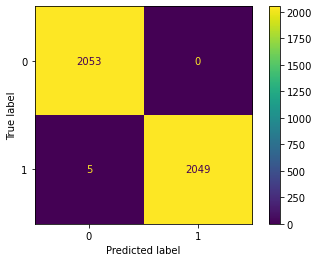

In [22]:
start = timer()
#Train the model using the training sets
pipe_scaler_rus.fit(X_train_rus,y_train_rus)
# 
p_start = timer()
y_predXGB = pipe_scaler_rus.predict(X_test_rus)
p_end = timer()
print('\n')
print(classification_report(y_test_rus, y_predXGB))
print(xgb_scaler_rus)
print('\n')
cm = confusion_matrix(y_test_rus, y_predXGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=pipe_scaler_rus.named_steps['xgb'].classes_)
disp.plot()
df = pd.DataFrame(pipe_scaler_rus.named_steps['xgb'].feature_importances_, index=X_test_rus.columns, 
                  columns=["XGB %-importance"])
print(df.sort_values("XGB %-importance", axis=0, ascending=False))
# 
data = [ID, 'XGB - Standard - UnderSample', (p_start - start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print('\n')
print(f'{(end - start)} Sec elapsed.')

#### XGB Classifier Model with Norml Under-Sampled Dataset



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

[('normal', MinMaxScaler()), ('xgb', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=11, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosit

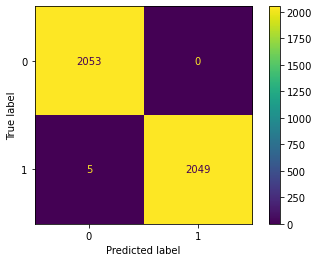

In [23]:
start = timer()
#Train the model using the training sets
pipe_normal_rus.fit(X_train_rus,y_train_rus)
# 
p_start = timer()
y_predXGB = pipe_normal_rus.predict(X_test_rus)
p_end = timer()
print('\n')
print(classification_report(y_test_rus, y_predXGB))
print(xgb_normal_rus)
print('\n')
cm = confusion_matrix(y_test_rus, y_predXGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=pipe_normal_rus.named_steps['xgb'].classes_)
disp.plot()
df = pd.DataFrame(pipe_normal_rus.named_steps['xgb'].feature_importances_, index=X_test_rus.columns, 
                  columns=["XGB %-importance"])
print(df.sort_values("XGB %-importance", axis=0, ascending=False))
# 
data = [ID, 'XGB - Normalize - UnderSample', (p_start - start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
# 
end = timer()
print('\n')
print(f'{(end - start)} Sec elapsed.')

#### XGB Classifier Model with Non-Standarized Under Sampled Dataset



              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=11, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


                    XGB %-i

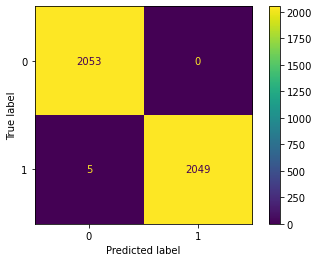

In [24]:
start = timer()
# Standard XGB Model
xgb_rus_ns = XGBClassifier(**params_xgb)
# 
s_start = timer()
#Train the model using the training sets
xgb_rus_ns.fit(X_train_rus,y_train_rus)
# 
p_start = timer()
y_predXGB_ns = xgb_rus_ns.predict(X_test_rus)
p_end = timer()
print('\n')
print(classification_report(y_test_rus, y_predXGB_ns))
print(xgb_rus_ns)
print('\n')
cm = (confusion_matrix(y_test_rus, y_predXGB_ns))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_rus_ns.classes_)
disp.plot()
df = pd.DataFrame(xgb_rus_ns.feature_importances_, index=X_test_rus.columns, columns=["XGB %-importance"])
print(df.sort_values("XGB %-importance", axis=0, ascending=False))
# 
data = [ID, 'XGB - NonStandard - UnderSample', (p_start - s_start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
# 
end = timer()
print('\n')
print(f'{(end - start)} Sec elapsed.')

#### XGB Classifier Model with Non Standarized Full sample Data



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      1.00      1.00      2053

    accuracy                           1.00   1590655
   macro avg       1.00      1.00      1.00   1590655
weighted avg       1.00      1.00      1.00   1590655

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=11, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='approx',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


                    XGB %-

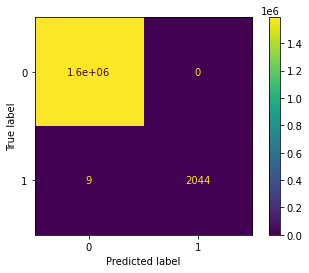

In [25]:
start = timer()
# Standard XGB Model
xgb_nsf = XGBClassifier(**params_xgb)
#Train the model using the training sets
s_start = timer()
xgb_nsf.fit(X_train_nsf,y_train_nsf)
# 
p_start = timer()
y_predXGB_nsf = xgb_nsf.predict(X_test_nsf)
p_end = timer()
print('\n')
print(classification_report(y_test_nsf, y_predXGB_nsf))
print(xgb_nsf)
print('\n')
cm = confusion_matrix(y_test_nsf, y_predXGB_nsf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_nsf.classes_)
disp.plot()
df = pd.DataFrame(xgb_nsf.feature_importances_, index=X_test_nsf.columns, columns=["XGB %-importance"])
print(df.sort_values("XGB %-importance", axis=0, ascending=False))
#  
data = [ID, 'XGB - NonStandard - Full', (p_start - s_start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
# 
end = timer()
print('\n')
print(f'{(end - start)/60} Min elapsed.')

#### XGB Classifier Model with NON-Standarized SMOTE Dataset



              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      1.00      1.00   1588602

    accuracy                           1.00   3177204
   macro avg       1.00      1.00      1.00   3177204
weighted avg       1.00      1.00      1.00   3177204

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, random_state=11, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='approx',
              use_label_encoder=False, validate_parameters=1, verbosity=None)


                    XGB %-

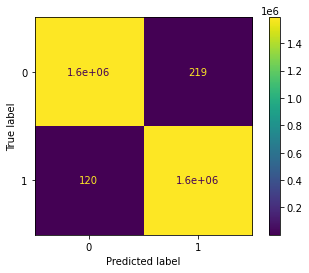

In [26]:
start = timer()
# Standard XGB Model
xgb_ = XGBClassifier(**params_xgb)
s_start = timer()
#Train the model using the training sets
xgb_.fit(X_train_nso,y_train_nso)
# 
p_start = timer()
y_predXGB_nso = xgb_.predict(X_test_nso)
p_end = timer()
print('\n')
print(classification_report(y_test_nso, y_predXGB_nso))
print(xgb_)
print('\n')
cm = confusion_matrix(y_test_nso, y_predXGB_nso)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_.classes_)
disp.plot()
df = pd.DataFrame(xgb_.feature_importances_, index=X_test_nso.columns, columns=["XGB %-importance"])
print(df.sort_values("XGB %-importance", axis=0, ascending=False))
#  
data = [ID, 'XGB - NonStandard - OverSample', (p_start - s_start), (p_end - p_start), cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print('\n')
print(f'{(end - start)/60} Min elapsed.')

#### XGB GridSearchCV with StratifiedKFold & Standarized Under Sampled Dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

                    XGB %-importance
newbalanceOrig              0.597151
diffBalanceOrig             0.362766
amount                      0.016556
transType_PAYMENT           0.007228
diffBalanceDest             0.006720
oldbalanceDest              0.001950
transType_TRANSFER          0.001751
oldbalanceOrig              0.001675
step                        0.001657
transType_CASH_OUT          0.001350
newbalanceDest              0.001195
transType_DEBIT             0.000000
nameDest_M                  0.000000


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
           

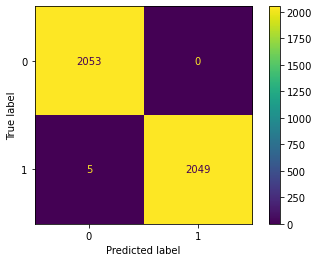

In [27]:
start = timer()
# 
from sklearn.model_selection import StratifiedKFold
# 
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds, random_state=seed, shuffle=True)
# 
params_grid = {
    'n_estimators': range(340, 360, 5,),
#     'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5],
}
# create xgboost classifier
xgb_cl1 = XGBClassifier(**params_xgb)
# 
xgb_grid = GridSearchCV(estimator=xgb_cl1, param_grid=params_grid, 
                               cv=skf.split(X_train_rus, y_train_rus), scoring='f1')

s_start = timer()
#Train the model using the training sets
xgb_grid.fit(X_train_rus,y_train_rus)
# 
p_start = timer()
y_predXGB1 = xgb_grid.predict(X_test_rus)
p_end = timer()
print(classification_report(y_test_rus, y_predXGB1))
# Plot Confusion Matrix
cm = confusion_matrix(y_test_rus, y_predXGB1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_grid.classes_)
disp.plot()
# 
df = pd.DataFrame(xgb_grid.best_estimator_.feature_importances_, index=X_test_rus.columns, columns=["XGB %-importance"])
print(df.sort_values("XGB %-importance", axis=0, ascending=False))
print('\n')
# 
print(xgb_grid.best_estimator_)
#  
data = [ID, 'XGB - Standard - UnderSample - StratifiedKFold Grid', (p_start - s_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#         
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print('\n')
print(f'{(end - start)} Sec elapsed.')

#### XGB GridSearchCV with StratifiedKFold & NON Standarized Under Sampled Dataset

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

                    XGB %-importance
newbalanceOrig              0.597151
diffBalanceOrig             0.362766
amount                      0.016556
transType_PAYMENT           0.007228
diffBalanceDest             0.006720
oldbalanceDest              0.001950
transType_TRANSFER          0.001751
oldbalanceOrig              0.001675
step                        0.001657
transType_CASH_OUT          0.001350
newbalanceDest              0.001195
transType_DEBIT             0.000000
nameDest_M                  0.000000


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
           

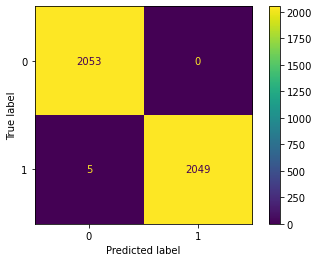

In [28]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import StratifiedKFold
# Non Standarized Dataset
start = timer()
# 
n_folds = 3
skf = StratifiedKFold(n_splits=n_folds, random_state=seed, shuffle=True)
# 
params_grid = {
# 'n_estimators': range(340, 360, 5,),
'n_estimators': [200, 340, 500],
# 'learning_rate': [0.1, 0.2, 0.3, 0.5, 0.6],
}
# create xgboost classifier
xgb_cl2 = XGBClassifier(**params_xgb)
# 
xgb_grid2 = GridSearchCV(estimator=xgb_cl2, param_grid=params_grid, 
                               cv=skf.split(X_train_rus, y_train_rus), scoring='f1')
# 
s_start = timer()
#Train the model using the training sets
xgb_grid2.fit(X_train_rus,y_train_rus)
# 
p_start = timer()
y_predXGB2 = xgb_grid2.predict(X_test_rus)
p_end = timer()
print(classification_report(y_test_rus, y_predXGB2))
# Plot Confusion Matrix
cm = confusion_matrix(y_test_rus, y_predXGB2)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb_grid2.classes_)
disp.plot()
# 
df = pd.DataFrame(xgb_grid2.best_estimator_.feature_importances_, 
                  index=X_test_rus.columns, columns=["XGB %-importance"])
print(df.sort_values("XGB %-importance", axis=0, ascending=False))
print('\n')
# 
print(xgb_grid2.best_estimator_)
print('\n')
#  
data = [ID, 'XGB - NonStandard - UnderSample - StratifiedKFold Grid', (p_start - s_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print(f'{(end - start)} Sec elapsed.')

# LGBM Classifier

#### LGBM Classifier Model Pipeline

In [29]:
# For prediction_info
ID = 'LGBM'
# Pipeline
params_lgbm = {
    'num_threads' : (8),
    'n_jobs' : (-1),
    'random_state' : seed,
}
# 
lgbm_scaler_rus = [('scaler', StandardScaler()), ('lgbm', LGBMClassifier(**params_lgbm))]
lgbm_normal_rus = [('normal', MinMaxScaler()), ('lgbm', LGBMClassifier(**params_lgbm))]
lgbm_scaler_nso = [('scaler', StandardScaler()), ('lgbm', LGBMClassifier(**params_lgbm))]
lgbm_normal_nsf = [('normal', MinMaxScaler()), ('lgbm', LGBMClassifier(**params_lgbm))]
# under sample
pipe_scaler_rus = Pipeline(lgbm_scaler_rus)
pipe_normal_rus = Pipeline(lgbm_normal_rus)
# Over sample (SMOTE)
pipe_nso = Pipeline(lgbm_scaler_nso)
# Full
pipe_nsf = Pipeline(lgbm_normal_nsf)

#### LGBM Classifier with Scaler Under-Sampled Dataset

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgbm', LGBMClassifier(num_threads=8, random_state=11))])


0.14185775400005696 Sec elapsed.


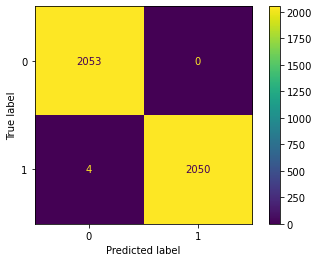

In [30]:
# 
start = timer()
#Train the model using the training sets
pipe_scaler_rus.fit(X_train_rus, y_train_rus)
# 
p_start = timer()
y_predLGB = pipe_scaler_rus.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predLGB))
cm = confusion_matrix(y_test_rus, y_predLGB)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=pipe_scaler_rus.named_steps['lgbm'].classes_)
disp.plot()
# 
print(pipe_scaler_rus)
print('\n')
#  
data = [ID, 'LGBM - Standard - UnderSample', (p_start - p_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print(f'{(end - start)} Sec elapsed.')

#### LGBM Classifier with Normalize Under-Sampled Dataset

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgbm', LGBMClassifier(num_threads=8, random_state=11))])


0.12090512099985062 Sec elapsed.


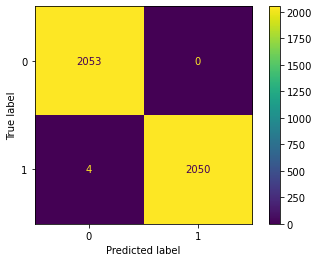

In [31]:
# 
start = timer()
#Train the model using the training sets
pipe_normal_rus.fit(X_train_rus, y_train_rus)
# 
p_start = timer()
y_predLGB = pipe_normal_rus.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predLGB))
# 
cm = confusion_matrix(y_test_rus, y_predLGB)
disp = ConfusionMatrixDisplay(confusion_matrix=(confusion_matrix(y_test_rus, y_predLGB)), 
                              display_labels=pipe_normal_rus.named_steps['lgbm'].classes_)
disp.plot()
# 
print(pipe_scaler_rus)
print('\n')  
data = [ID, 'LGBM - Normalize - UnderSample', (p_start - p_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print(f'{(end - start)} Sec elapsed.')

#### LGBM Classifier with NON-Standarized Under-Sampled Dataset

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2053
           1       1.00      1.00      1.00      2054

    accuracy                           1.00      4107
   macro avg       1.00      1.00      1.00      4107
weighted avg       1.00      1.00      1.00      4107

LGBMClassifier(num_threads=8, random_state=11)


0.12543985399997837 Sec elapsed.


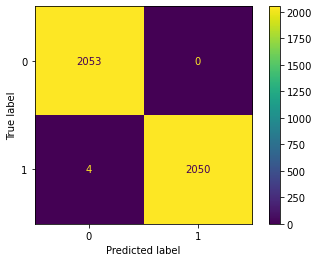

In [32]:
# from lightgbm import LGBMClassifier
start = timer()
# Define model
lgb_ns = LGBMClassifier(**params_lgbm)
# 
s_start = timer()
#Train the model using the training sets
lgb_ns.fit(X_train_rus,y_train_rus)
# 
p_start = timer()
y_predLGB_ns=lgb_ns.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predLGB_ns))
# 
cm = confusion_matrix(y_test_rus, y_predLGB_ns)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_ns.classes_)
disp.plot()
# 
print(lgb_ns)
print('\n')
# 
data = [ID, 'LGBM - NonStandard - UnderSample', (p_start - s_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print(f'{(end - start)} Sec elapsed.')

#### LGBM Classifier with NON-Standarized Full Dataset

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.03      0.05      0.03      2053

    accuracy                           1.00   1590655
   macro avg       0.51      0.52      0.52   1590655
weighted avg       1.00      1.00      1.00   1590655

LGBMClassifier(num_threads=8, random_state=11)


12.26413708899986 Sec elapsed.


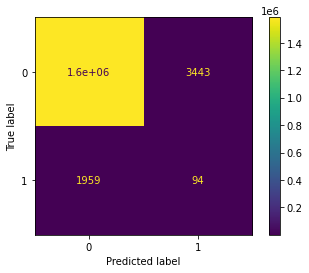

In [33]:
# from lightgbm import LGBMClassifier
start = timer()
# Define model
lgb_nsf = LGBMClassifier(**params_lgbm)
# 
s_start = timer()
#Train the model using the training sets
lgb_nsf.fit(X_train_nsf,y_train_nsf)
# 
p_start = timer()
y_predLGB_nsf = lgb_nsf.predict(X_test_nsf)
p_end = timer()
# 
print(classification_report(y_test_nsf, y_predLGB_nsf))
cm = confusion_matrix(y_test_nsf, y_predLGB_nsf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_nsf.classes_)
disp.plot()
# 
print(lgb_nsf)
print('\n')
# 
data = [ID, 'LGBM - NonStandard - Full', (p_start - s_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print(f'{(end - start)} Sec elapsed.')

#### LGBM Classifier with NON-Standarized SMOTE Dataset

[LightGBM] [Warning] num_threads is set=8, n_jobs=-1 will be ignored. Current value: num_threads=8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       1.00      1.00      1.00   1588602

    accuracy                           1.00   3177204
   macro avg       1.00      1.00      1.00   3177204
weighted avg       1.00      1.00      1.00   3177204

LGBMClassifier(num_threads=8, random_state=11)


29.086973366999928 Sec elapsed.


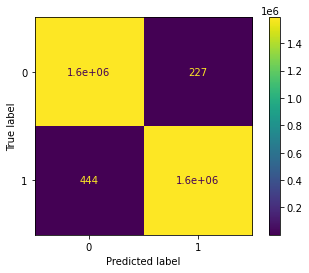

In [34]:
# from lightgbm import LGBMClassifier
start = timer()
# Define model
lgb_nso = LGBMClassifier(**params_lgbm)
# 
s_start = timer()
#Train the model using the training sets
lgb_nso.fit(X_train_nso,y_train_nso)
# 
p_start = timer()
y_predLGB_nso = lgb_nso.predict(X_test_nso)
p_end = timer()
# 
print(classification_report(y_test_nso, y_predLGB_nso))
cm = confusion_matrix(y_test_nso, y_predLGB_nso)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lgb_nso.classes_)
disp.plot()
# 
print(lgb_nso)
print('\n')
# 
data = [ID, 'LGBM - NonStandard - OverSample', (p_start - s_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print(f'{(end - start)} Sec elapsed.')

# Support Vector Machine

#### SVM Classifier Model Pipeline

In [35]:
# For prediction_info
ID = 'SVM'
# Pipeline
params_svc = {
    'gamma' : 'auto',
#     'gamma' : 'scale',
    'probability' : True,
    'random_state' : seed,
}
# 
svc_scaler_rus = [('scaler', StandardScaler()), ('svm', svm.SVC(**params_svc))]
svc_normal_rus = [('normal', MinMaxScaler()), ('svm', svm.SVC(**params_svc))]
svc_scaler_nso = [('scaler', StandardScaler()), ('svm', svm.SVC(**params_svc))]
svc_normal_nsf = [('normal', MinMaxScaler()), ('svm', svm.SVC(**params_svc))]
# under sample
pipe_scaler_rus = Pipeline(svc_scaler_rus)
pipe_normal_rus = Pipeline(svc_normal_rus)
# Over sample (SMOTE)
pipe_nso = Pipeline(svc_scaler_nso)
# Full
pipe_nsf = Pipeline(svc_normal_nsf)

#### Support Vector Machine Classifier with Scaler Under-Sampled Dataset

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2053
           1       0.92      0.99      0.95      2054

    accuracy                           0.95      4107
   macro avg       0.95      0.95      0.95      4107
weighted avg       0.95      0.95      0.95      4107

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(gamma='auto', probability=True, random_state=11))])


9.169515000000047 Sec elapsed.


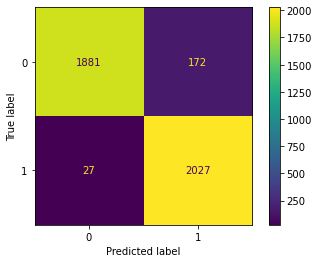

In [36]:
# 
start = timer()
# Train / Fit Model
pipe_scaler_rus.fit(X_train_rus, y_train_rus)
# 
p_start = timer()
y_predSVC_rus = pipe_scaler_rus.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predSVC_rus))
cm = confusion_matrix(y_test_rus, y_predSVC_rus)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=pipe_scaler_rus.named_steps['svm'].classes_)
disp.plot()
# 
print(pipe_scaler_rus)
print('\n')
# 
data = [ID, 'SVM - Standard - UnderSample', (p_start - s_start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print(f'{(end - start)} Sec elapsed.')

#### Support Vector Machine Classifier with Normalize Under-Sampled Dataset

              precision    recall  f1-score   support

           0       0.99      0.92      0.95      2053
           1       0.92      0.99      0.95      2054

    accuracy                           0.95      4107
   macro avg       0.95      0.95      0.95      4107
weighted avg       0.95      0.95      0.95      4107

Pipeline(steps=[('normal', MinMaxScaler()),
                ('svm', SVC(gamma='auto', probability=True, random_state=11))])


0.33852845388333513 Min elapsed.


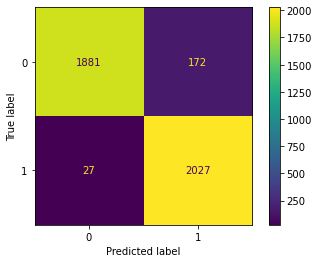

In [37]:
# 
start = timer()
# Train / Fit Model
pipe_normal_rus.fit(X_train_rus, y_train_rus)
# 
p_start = timer()
y_predSVC_rus = pipe_scaler_rus.predict(X_test_rus)
p_end = timer()
# 
print(classification_report(y_test_rus, y_predSVC_rus))
cm = confusion_matrix(y_test_rus, y_predSVC_rus)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=pipe_normal_rus.named_steps['svm'].classes_)
disp.plot()
# 
print(pipe_normal_rus)
# 
data = [ID, 'SVM - Normalize - UnderSample', (p_start - start), (p_end - p_start), 
        cm[1,0], cm[0,1], cm.sum()]
#          
for key, data in zip(keys,data):
    prediction_info[key].append(data)
#
end = timer()
print('\n')
print(f'{(end - start)/60} Min elapsed.')

In [38]:
pd.DataFrame(prediction_info)

,ID,Algorithm,TrainingTime_sec,PredictionTime_sec,False Negative,False Positive,Total Records
0,RF,RFC - Normalize - UnderSample,0.252569,0.028870,5,0,4107
1,RF,RFC - Standard - UnderSample,0.206112,0.027877,5,0,4107
2,RF,RFC - NonStandard - UnderSample,0.210386,0.028174,5,0,4107
3,RF,RFC - NonStandard - Full,162.886086,1.651865,10,0,1590655
4,RF,RFC - NonStandard - OverSample,322.578442,3.305756,55,47,3177204
5,RF,RFC - NonStandard - UnderSample - RandomGridSe...,245.697482,0.098610,3,0,4107
6,XGB,XGB - Standard - UnderSample,0.338135,0.005608,5,0,4107
7,XGB,XGB - Normalize - UnderSample,0.330252,0.005928,5,0,4107
8,XGB,XGB - NonStandard - UnderSample,0.333772,0.003874,5,0,4107
9,XGB,XGB - NonStandard - Full,213.564923,0.400996,9,0,1590655
